In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

functions define

In [193]:
def get_data_dict(data):
    data_dict = {}
    for m in range(12):
        row = m*18*20
        temp = data.iloc[row:row+18]
        for d in range(1,20):
            row += 18
            temp = pd.concat([temp,data.iloc[row:row+18]],axis=1)
        temp.set_axis(range(24*20),axis=1,inplace=True)
        data_dict[m] = temp
    return data_dict

def getMonthTrainData(month,hours,features):
    label = month.loc['PM2.5',hours:]
    X = np.empty((480-hours,len(features)*hours))
    for i in range(480-hours):
        X[i,:] = month.loc[features,i:i+hours-1].values.flatten()
    return X,label.values.astype(np.float)

def getYearTrainData(dict,hours,features):
    X,y = getMonthTrainData(dict[0],hours,features)
    for m in range(1,12):
        temp_X,temp_y = getMonthTrainData(dict[m],hours,features)
        X = np.concatenate((X,temp_X),axis=0)
        y = np.concatenate((y,temp_y),axis=0)
    return X,y.reshape(y.shape[0],-1)

def normal(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X-mu)/sigma,mu,sigma

def loss_fun(theta,X,y,lbd=0):
    m = y.shape[0]
    theta_1 = theta.copy()
    theta_1[0] = 0
    X = np.concatenate((np.ones((m,1),dtype=np.float),X),axis=1)
    y_pred = X@theta
    temp = y_pred - y
    loss = temp.T@temp/m/2 + lbd/2/m*theta_1.T@theta_1
    grad = X.T@temp/m + lbd/m*theta_1
    return loss.item(),grad

def gradDecent(init_theta,X_train,y_train,X_test=[],y_test=[],lr=0.01,iteration=1000,lbd=0):
    theta = init_theta.copy()
    loss,grad = loss_fun(theta,X_train,y_train,lbd=lbd)
    
    if len(X_test)!=0:
        loss_val,_ = loss_fun(theta,X_test,y_test,lbd=0)
    loss_history = []
    loss_val_history = []
    sum_grad_sqrt = 0
    for i in range(iteration):
        loss_history.append(loss)
        if len(X_test)!=0:
            loss_val_history.append(loss_val)
        sum_grad_sqrt += grad**2
        theta = theta - lr*grad/np.sqrt(sum_grad_sqrt)
        theta = theta - lr*grad
        loss,grad = loss_fun(theta,X_train,y_train,lbd=lbd)
        if len(X_test)!=0:
            loss_val,_ = loss_fun(theta,X_test,y_test,lbd=0)
    return theta,loss_history,loss_val_history

读取训练数据

In [4]:
data = pd.read_csv('train.csv',engine='python')

data.columns = ['Date', 'Place', 'Test', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23']

data.drop(['Date','Place'],axis='columns',inplace=True)

data.set_index('Test',inplace=True)

data[data=='NR'] = 0

data = data.astype(np.float32)

data_dict = get_data_dict(data)


In [24]:
month1 = data_dict[0]

pm25 = np.array(month1.loc['PM2.5'])

从下图可以看出，PM2.5现在的值和之前的值之间存在明显的线性关系，所以我们可以通过历史值来预测PM2.5

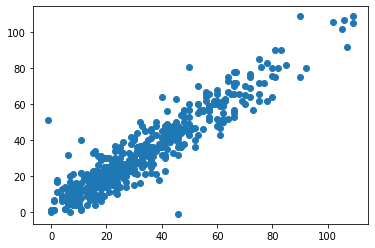

In [22]:
plt.scatter(pm25[:-1],pm25[1:])

In [76]:
lr = 0.1
iteration = 1000
best_train_loss,best_test_loss = (0,0)
last_hours = 0
last_features = []

hours from 0 to 1
features from [] to ['PM2.5']
train_loss from 0 to 21.48371425912089, test_loss from 0 to 24.577033658605558


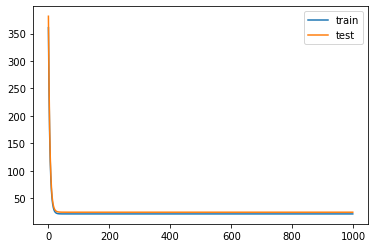

In [45]:
hours = 1
# features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
#        'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
#        'WIND_SPEED', 'WS_HR']
features = ['PM2.5']

X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))

theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)

last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)

print(f'hours from {last_hours} to {hours}')
print(f'features from {last_features} to {features}')
print(f'train_loss from {best_train_loss} to {last_loss}, test_loss from {best_test_loss} to {last_loss_val}')

best_train_loss,best_test_loss = (last_loss,last_loss_val)
last_hours = hours
last_features = features.copy()
      
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

使用前9个小时的PM2.5值来试试效果

hours from 1 to 9
features from ['PM2.5'] to ['PM2.5']
train_loss from 21.48371425912089 to 17.834221683170913, test_loss from 24.577033658605558 to 20.89297334830712


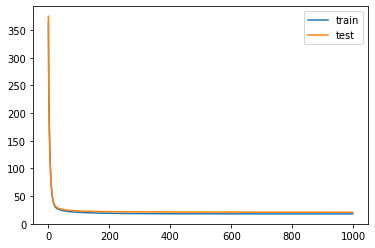

In [46]:
hours = 9
# features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
#        'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
#        'WIND_SPEED', 'WS_HR']
features = ['PM2.5']

X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))

theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)


print(f'hours from {last_hours} to {hours}')
print(f'features from {last_features} to {features}')
print(f'train_loss from {best_train_loss} to {last_loss}, test_loss from {best_test_loss} to {last_loss_val}')

best_train_loss,best_test_loss = (last_loss,last_loss_val)
last_hours = hours
last_features = features.copy()
      
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

可以看到，当PM2.5历史值增加到9个时，MSE在train set上从21.5下降到17.8，在test set上从24.6下降到20.9，性能提高了不少。

但是不是历史值越多越好呢？我来试试5个历史值的情况。

hours from 9 to 5
features from ['PM2.5'] to ['PM2.5']
train_loss from 17.834221683170913 to 19.231304173143204, test_loss from 20.89297334830712 to 19.35420013260805


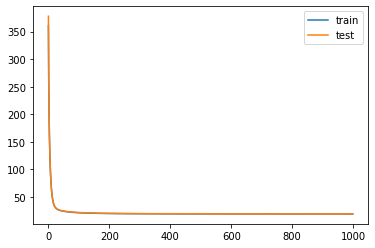

In [47]:
hours = 5
# features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
#        'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
#        'WIND_SPEED', 'WS_HR']
features = ['PM2.5']

X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))

theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)


print(f'hours from {last_hours} to {hours}')
print(f'features from {last_features} to {features}')
print(f'train_loss from {best_train_loss} to {last_loss}, test_loss from {best_test_loss} to {last_loss_val}')

best_train_loss,best_test_loss = (last_loss,last_loss_val)
last_hours = hours
last_features = features.copy()
      
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

可以看到，当PM2.5历史值从9个减少到5个时，MSE在train set上从17.8提高到19.2，但在test set上却从20.9下降到19.4，性能提高了。

看来历史值也不是越多越好啊。

我再看看PM2.5的分布

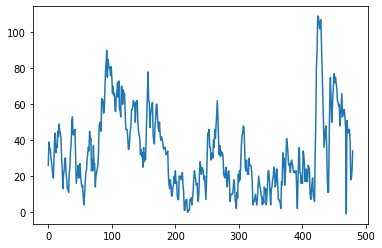

In [53]:
plt.plot(range(pm25.shape[0]),pm25)

hours from 7 to 5
features from ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'RH', 'SO2', 'WD_HR', 'WS_HR'] to ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'RH', 'SO2', 'WD_HR', 'WS_HR']
train_loss from 16.50825128794379 to 17.16684716784286, test_loss from 18.301928555782077 to 17.733781850937948


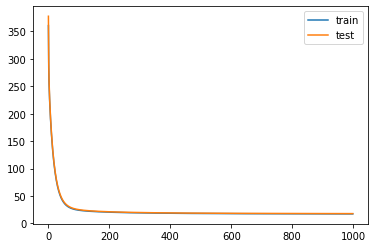

In [96]:
lr = 0.03

hours = 5
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5',  'RH', 'SO2', 'WD_HR', 
       'WS_HR']
# features = ['AMB_TEMP', 'NO2','O3','PM10','PM2.5', 'SO2']

X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))

theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)


print(f'hours from {last_hours} to {hours}')
print(f'features from {last_features} to {features}')
print(f'train_loss from {best_train_loss} to {last_loss}, test_loss from {best_test_loss} to {last_loss_val}')

best_train_loss,best_test_loss = (last_loss,last_loss_val)
last_hours = hours
last_features = features.copy()
      
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

用所有数据训练下

In [194]:
lr = 0.03

hours = 9
# features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
#        'PM2.5',  'RH', 'SO2', 'WD_HR', 
#        'WS_HR']
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR']

X,y = getYearTrainData(data_dict,hours,features)

X_train_norm,mu,sigma = normal(X)

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))

theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y,
                                                 X_test=[],y_test=[],lr=lr,iteration=iteration)

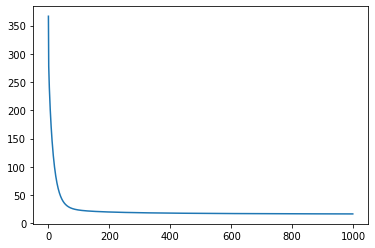

In [195]:
plt.plot(loss_history)

预测

In [196]:
data_test = pd.read_csv('test.csv',engine='python',header=None)
data_test.drop(0,axis='columns',inplace=True)
data_test.set_index(1,inplace=True)
data_test[data_test=='NR']=0
data_test=data_test.iloc[:,-hours:]
data_test = data_test.astype(np.float32)
data_test.head(18)

,2,3,4,5,6,7,8,9,10
1,,,,,,,,,
AMB_TEMP,21.00,21.00,20.00,20.00,19.00,19.00,19.00,18.00,17.00
CH4,1.70,1.70,1.70,1.70,1.70,1.70,1.70,1.70,1.80
CO,0.39,0.36,0.36,0.40,0.53,0.55,0.34,0.31,0.23
NMHC,0.16,0.24,0.22,0.27,0.27,0.26,0.27,0.29,0.10
NO,1.30,1.30,1.30,1.30,1.40,1.60,1.20,1.10,0.90
NO2,17.00,14.00,13.00,14.00,18.00,21.00,8.90,9.40,5.00
NOx,18.00,16.00,14.00,15.00,20.00,23.00,10.00,10.00,5.80
O3,32.00,31.00,31.00,26.00,16.00,12.00,27.00,20.00,26.00
PM10,62.00,50.00,44.00,39.00,38.00,32.00,48.00,36.00,25.00


In [197]:
num = 240
X_pred=np.empty((num,hours*len(features)),dtype=np.float32)
for i in range(num):
    pos=i*18
    X_pred[i,:] = np.array(data_test.iloc[pos:pos+18,:].loc[features]).flatten()

X_pred = (X_pred-mu)/sigma
    
X_pred = np.concatenate((np.ones((X_pred.shape[0],1),dtype=np.float),X_pred),axis=1)

y_pred = X_pred@theta

In [198]:
df_pred = pd.DataFrame(data={'id':[f'id_{i}' for i in range(num)],'value':y_pred.flatten()})

df_pred.head()

,id,value
0,id_0,4.795376
1,id_1,17.035627
2,id_2,24.300378
3,id_3,8.174104
4,id_4,27.755850


In [199]:
df_pred.to_csv('result.csv',index=False)